# Training Neural Networks on simulated single Tracks

Simple script to analyze simulated single tracks. Execute each cell one after the other. Many functions, like setting up the neural networks or calucalting the confusion matrix are defined in: "analysis_utils.py".

## Load libraries and settings

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import display
from analysis_utils import analysis_utils
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from joblib import dump

ana_utils = analysis_utils()

#MAKE CHANGES HERE
#*******************************************************************
charge = -1 #Choose -1 / 1 (negative / positive) for selecting a specific particle charge
ana_add_name = 'demo' #--> Change this to customize the name of the produced plots and trained networks
n_df_rows = 0 #Change this to a number > 0, if you want to print out the first n_df_rows rows of the dataframe

#Change these numbers to obtain a different identification performance:
#Lepton selection criteria:
e_over_p_min_lep = 0.7
e_over_p_max_lep = 1.2
fdc_min_lep = 1.8e-6
fdc_max_lep = 3.0e-6
cdc_min_lep = 1.75e-6
cdc_max_lep = 3.2e-6

#Pion selection criteria:
e_over_p_min_pi = 0.0
e_over_p_max_pi = 0.7
fdc_min_pi = 1.2e-6
fdc_max_pi = 2.5e-6
cdc_min_pi = 1.2e-6
cdc_max_pi = 2.25e-6
#*******************************************************************

## Load data frame

In [19]:
dataDir = 'http://hadron.physics.fsu.edu/~dlersch/Intro_To_ML_2021/data/'
particle_dict = {
    -1: ['Neg_LepPi_DF_small','Electrons','Negative Pions'], #--> You may remove the '_small' and anlyze the full data set discussed in the lecture 
     1: ['Pos_LegPi_DF_small','Positrons','Positive Pions'] 
}

plot_dict = {
    -1: ['electrons','neg_pions','neg_particles'],
    1: ['positrons','pos_pions','pos_particles'],
}

#Load the data frame:
data_df = pd.read_csv(dataDir + particle_dict[charge][0] + '.csv')
features = ['p','theta','ddEdx_CDC','dE_BCAL','ddEdx_FDC','dE_FCAL']

if n_df_rows > 0:
    print(data_df.head(n_df_rows))

## Add E/p information to the data frame

In [20]:
data_df['e_over_p_fcal'] = data_df['dE_FCAL'] / data_df['p']
data_df['e_over_p_bcal'] = data_df['dE_BCAL'] / data_df['p']

## Separate data accroding to particles going into the GlueX forward / central part

We need to define conditions that define particles going to the forward / central part:
Forward: no information in the central drift chamber (CDC) and central calorimeter (BCAL):

In [21]:
accept_forward = (data_df['dE_FCAL'] > 0.0) & (data_df['ddEdx_FDC'] > 0.0) & (data_df['dE_BCAL'] == 0.0) & (data_df['ddEdx_CDC'] == 0.0)
forward_data = data_df[accept_forward]

Central: no information in the forward drift chamber (FDC) and forward calorimeter (FCAL):

In [6]:
accept_central = (data_df['dE_FCAL'] == 0.0) & (data_df['ddEdx_FDC'] == 0.0) & (data_df['dE_BCAL'] > 0.0) & (data_df['ddEdx_CDC'] > 0.0)
central_data = data_df[accept_central]

## Visualize data correlations

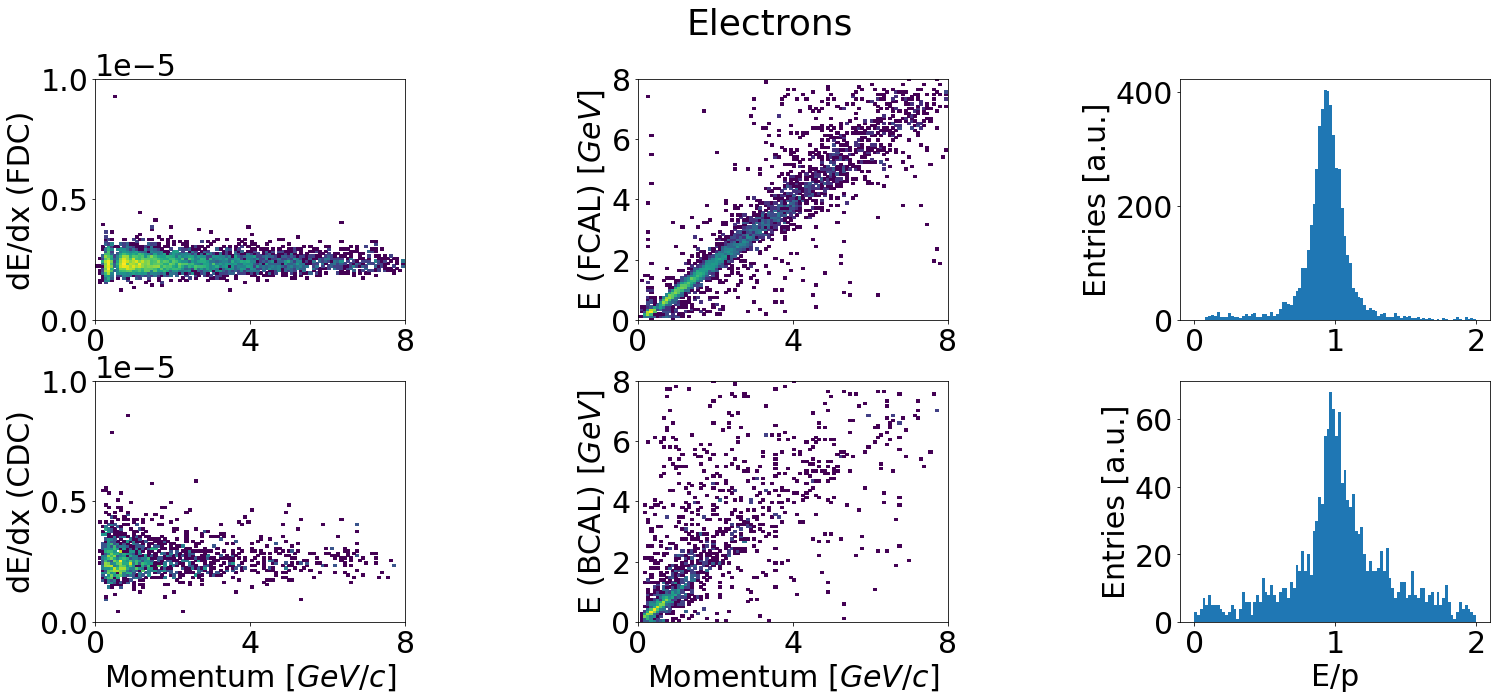

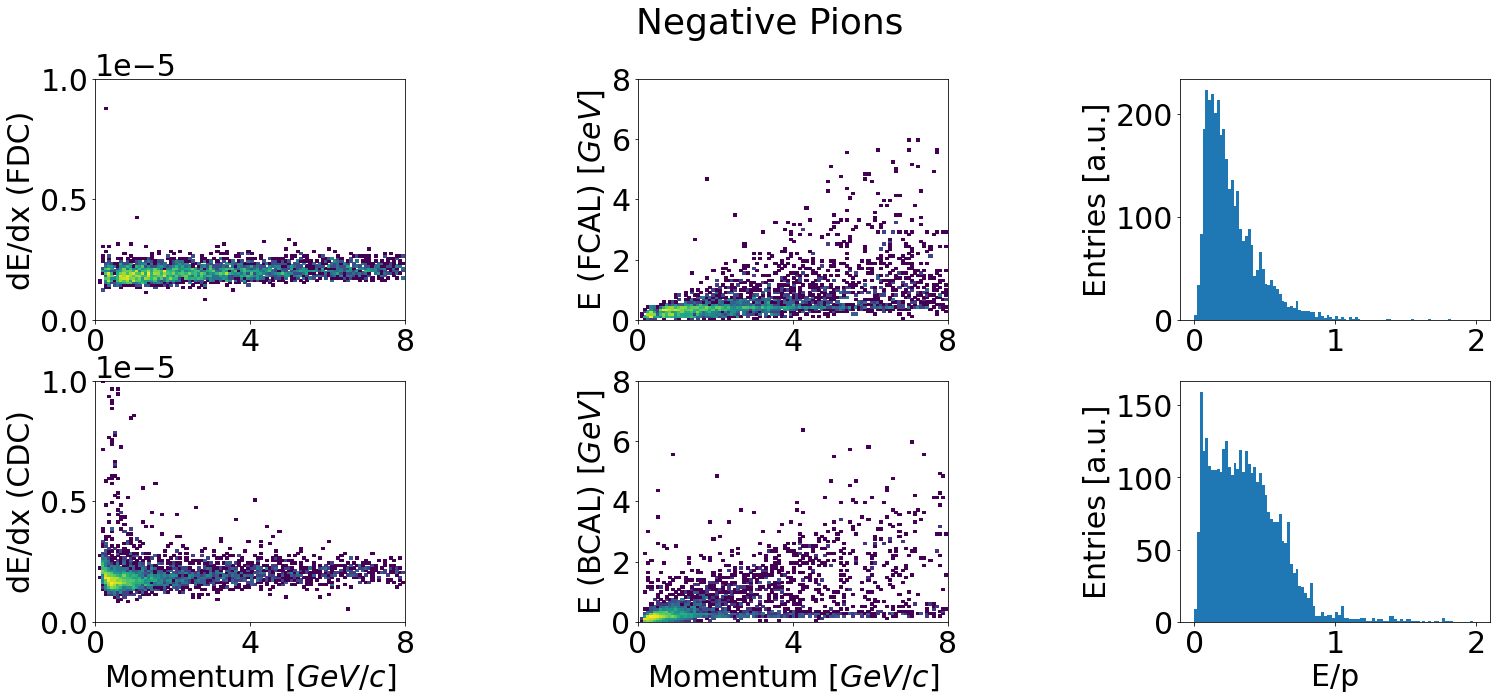

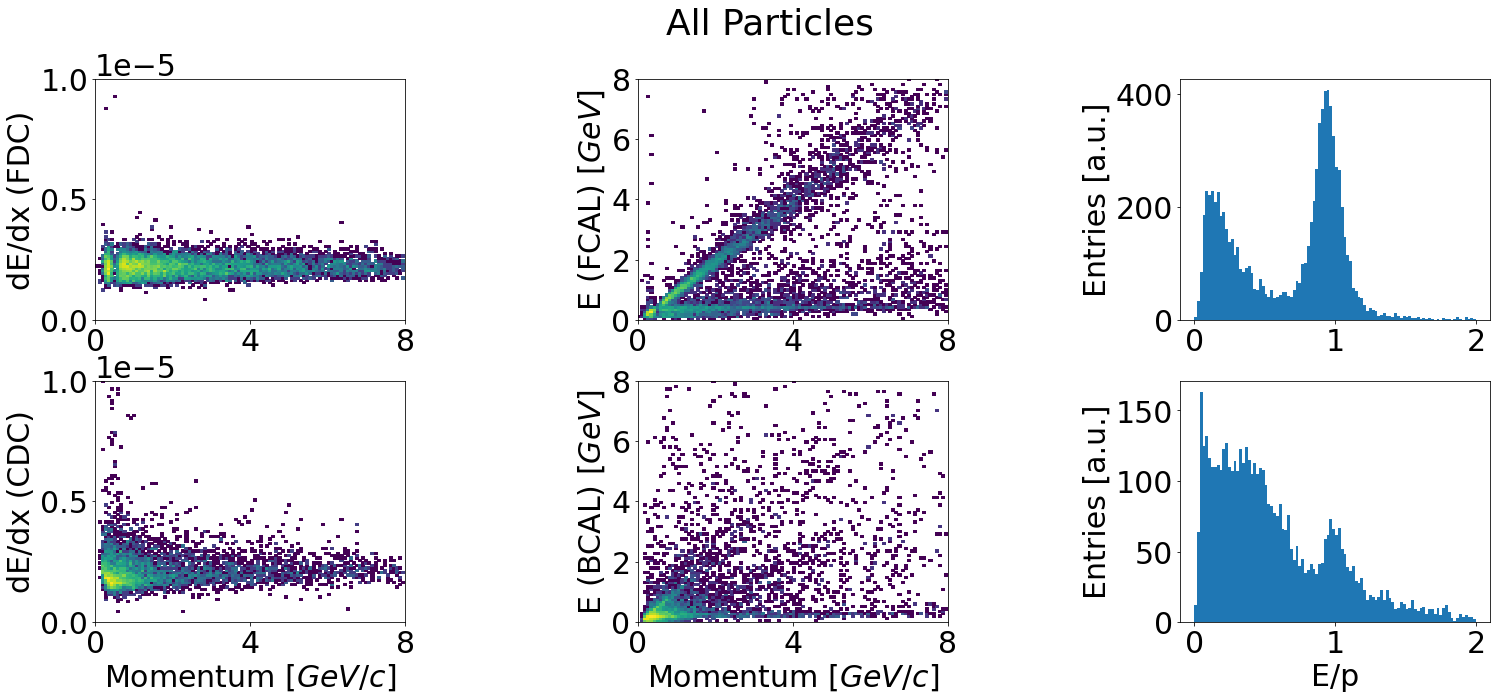

In [28]:
#look at leptons only:
is_lepton_forward = forward_data['label'] == 1
is_lepton_central = central_data['label'] == 1

plt.rcParams.update({'font.size': 30})
n_bins = 100

fig_lep,ax_lep = ana_utils.show_correlation([forward_data,central_data],[is_lepton_forward,is_lepton_central],particle_dict[charge][1],n_bins)
fig_lep.savefig('correlations_' + plot_dict[charge][0] + '_' + ana_add_name + '.png')

#look at pions only:
is_pion_forward = forward_data['label'] == 0
is_pion_central = central_data['label'] == 0

fig_pi,ax_pi = ana_utils.show_correlation([forward_data,central_data],[is_pion_forward,is_pion_central],particle_dict[charge][2],n_bins)
fig_pi.savefig('correlations_' + plot_dict[charge][1] + '.png')

fig_all,ax_all = ana_utils.show_correlation([forward_data,central_data],None,'All Particles',n_bins)
fig_all.savefig('correlations_' + plot_dict[charge][2] + '_' + ana_add_name + '.png')

## Get analysis conditions and visualize them

In [29]:
lepton_forward_pid, lepton_central_pid = ana_utils.get_pid_criteria([forward_data,central_data],e_over_p_min_lep,e_over_p_max_lep,fdc_min_lep,fdc_max_lep,cdc_min_lep,cdc_max_lep)
pion_forward_pid, pion_central_pid = ana_utils.get_pid_criteria([forward_data,central_data],e_over_p_min_pi,e_over_p_max_pi,fdc_min_pi,fdc_max_pi,cdc_min_pi,cdc_max_pi)

#Visualize analysis conditions within the plots we created earlier:

#Leptons:
#Forward:
ax_lep[0,0].plot([0.0,8.0],[fdc_min_lep,fdc_min_lep],'r-',linewidth=2.0)
ax_lep[0,0].plot([0.0,8.0],[fdc_max_lep,fdc_max_lep],'r-',linewidth=2.0)

ax_lep[0,2].plot([e_over_p_min_lep,e_over_p_min_lep],[0.0,5000],'r--',linewidth=2.0)
ax_lep[0,2].plot([e_over_p_max_lep,e_over_p_max_lep],[0.0,5000],'r--',linewidth=2.0)

#Central:
ax_lep[1,0].plot([0.0,8.0],[cdc_min_lep,cdc_min_lep],'r-',linewidth=2.0)
ax_lep[1,0].plot([0.0,8.0],[cdc_max_lep,cdc_max_lep],'r-',linewidth=2.0)

ax_lep[1,2].plot([e_over_p_min_lep,e_over_p_min_lep],[0.0,5000],'r--',linewidth=2.0)
ax_lep[1,2].plot([e_over_p_max_lep,e_over_p_max_lep],[0.0,5000],'r--',linewidth=2.0)

fig_lep.savefig('correlations_' + plot_dict[charge][0] + '_' + ana_add_name + '_pid.png')

#Pions
#Forward:
ax_pi[0,0].plot([0.0,8.0],[fdc_min_pi,fdc_min_pi],'r-',linewidth=2.0)
ax_pi[0,0].plot([0.0,8.0],[fdc_max_pi,fdc_max_pi],'r-',linewidth=2.0)

ax_pi[0,2].plot([e_over_p_min_pi,e_over_p_min_pi],[0.0,4000],'r--',linewidth=2.0)
ax_pi[0,2].plot([e_over_p_max_pi,e_over_p_max_pi],[0.0,4000],'r--',linewidth=2.0)

#Central:
ax_pi[1,0].plot([0.0,8.0],[cdc_min_pi,cdc_min_pi],'r-',linewidth=2.0)
ax_pi[1,0].plot([0.0,8.0],[cdc_max_pi,cdc_max_pi],'r-',linewidth=2.0)

ax_pi[1,2].plot([e_over_p_min_pi,e_over_p_min_pi],[0.0,2000],'r--',linewidth=2.0)
ax_pi[1,2].plot([e_over_p_max_pi,e_over_p_max_pi],[0.0,2000],'r--',linewidth=2.0)

fig_pi.savefig('correlations_' + plot_dict[charge][1] + '_' + ana_add_name + '_pid.png')

## Apply PID conditions and merge data

Now we apply the analysis conditions and merge forward / central and pion / lepton data to one data set:

Note: This step seems a bit clumsy / unecessary (yes, it is!), but for the sake of simplicity / eduction it was done this way

In [10]:
leptons_forward = forward_data.copy(deep=True)
leptons_forward.loc[lepton_forward_pid,'is_lepton'] = 1.0 #--> events fulfilling the lepton conditions are labeled with 1
leptons_forward.loc[~lepton_forward_pid,'is_lepton'] = 0.0 #---> events NOT fulfilling the lepton conditions are labeled with 0

leptons_central = central_data.copy(deep=True)
leptons_central.loc[lepton_central_pid,'is_lepton'] = 1.0 #--> events fulfilling the lepton conditions are labeled with 1
leptons_central.loc[~lepton_central_pid,'is_lepton'] = 0.0 #---> events NOT fulfilling the lepton conditions are labeled with 0

pions_forward = forward_data.copy(deep=True)
pions_forward.loc[pion_forward_pid,'is_lepton'] = 0.0 #--> events fulfilling the pion conditions are labeled with 0
pions_forward.loc[~pion_forward_pid,'is_lepton'] = 1.0 #--> events NOT fulfilling the pion conditions are labeled with 1

pions_central = central_data.copy(deep=True)
pions_central.loc[pion_central_pid,'is_lepton'] = 0.0 #--> events fulfilling the pion conditions are labeled with 0
pions_central.loc[~pion_central_pid,'is_lepton'] = 1.0 #--> events NOT fulfilling the pion conditions are labeled with 1


pid_data = pd.concat([leptons_forward,leptons_central,pions_forward,pions_central])

## Obtain PID performance for the applied analysis conditions

The following lines show nicely, how easy / fast data anlysis can be done on an existing data frame

In [12]:
n_leptons = pid_data[pid_data['label'] == 1.0].shape[0]
n_leptons_accepted = pid_data[(pid_data['is_lepton'] == 1.0) & (pid_data['label'] == 1.0)].shape[0]
n_pions_accepted_lepton = pid_data[(pid_data['is_lepton'] == 1.0) & (pid_data['label'] == 0.0)].shape[0]

n_pions = pid_data[pid_data['label'] == 0.0].shape[0]
n_pions_accepted = pid_data[(pid_data['is_lepton'] == 0.0) & (pid_data['label'] == 0.0)].shape[0]
n_leptons_accepted_pion = pid_data[(pid_data['is_lepton'] == 0.0) & (pid_data['label'] == 1.0)].shape[0]

lepton_positive_rate = n_leptons_accepted / float(n_leptons)
lepton_false_positive_rate = n_pions_accepted_lepton / float(n_pions)

pion_positive_rate = n_pions_accepted / float(n_pions)
pion_false_positive_rate = n_leptons_accepted_pion / float(n_leptons)

accuracy = accuracy_score(pid_data['label'],pid_data['is_lepton'])
mcc = matthews_corrcoef(pid_data['label'],pid_data['is_lepton'])

#Display results:
print("  ")
print("Lepton identification performance:")
print("------------------------------------")
print("True positive rate: " + str(lepton_positive_rate))
print("False positive rate: " + str(lepton_false_positive_rate))
print("------------------------------------")

print("  ")
print("Pion identification performance:")
print("--------------------------------")
print("True positive rate: " + str(pion_positive_rate))
print("False positive rate: " + str(pion_false_positive_rate))
print("--------------------------------")

print("  ")
print("Overall identification performance:")
print("-----------------------------------")
print("Accuracy: " + str(accuracy))
print("MCC: " + str(mcc))
print("-----------------------------------")
print("  ")

  
Lepton identification performance:
------------------------------------
True positive rate: 0.8486179095882522
False positive rate: 0.10288270377733598
------------------------------------
  
Pion identification performance:
--------------------------------
True positive rate: 0.897117296222664
False positive rate: 0.15138209041174777
--------------------------------
  
Overall identification performance:
-----------------------------------
Accuracy: 0.8730340291678582
MCC: 0.7467918633568276
-----------------------------------
  


## Calculate confusion matrix for the applied analysis conditions

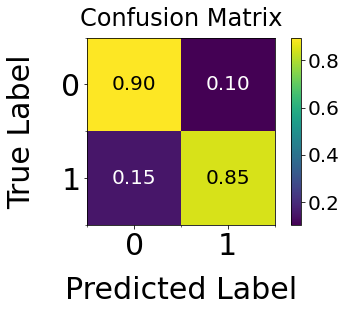

In [30]:
fig_cm,ax_cm = ana_utils.get_confusion_matrix(pid_data,'label','is_lepton',[0,1],'Confusion Matrix')
fig_cm.savefig('confusion_matrix_' + plot_dict[charge][2] + '_' + ana_add_name + '.png')

## Prepare data for machine learning algorithms

In [14]:
X = data_df[features]
Y = data_df['label']

## Set up a neural networks (scikit and Tensorflow / Keras)

In [33]:
scikit_mlp_classifier = ana_utils.set_scikit_mlp_classifier((8,5),'relu',200,0.5,0.05) #--> Check analysis_utils.py to see which arguments are used and how
keras_mlp_classifier = ana_utils.set_keras_mlp_classifier(len(features),1,(8,5),('relu','relu'),'sigmoid',0.05,loss_function='binary_xentropy',print_summary=True)

 
Model: "keras_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
 


## Train and save both classifiers

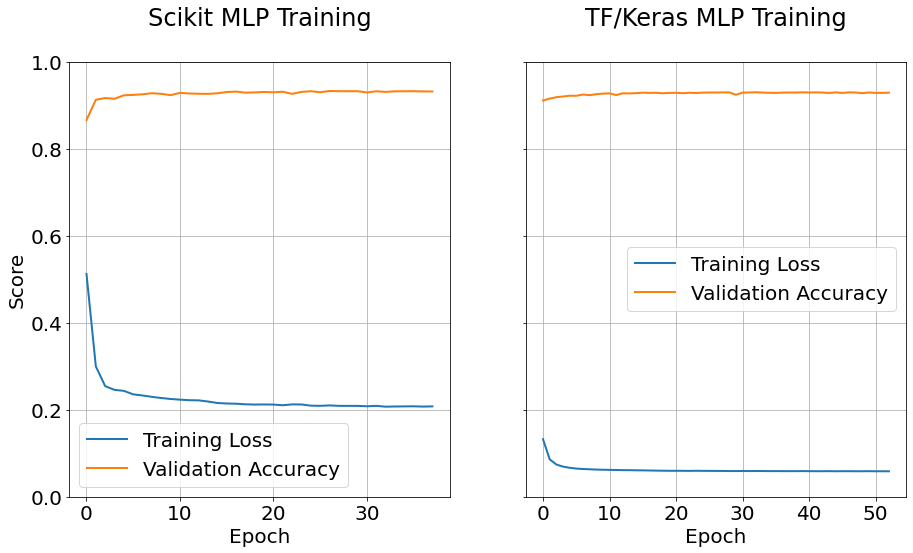

In [34]:
scikit_mlp_classifier.fit(X,Y)
keras_train_hist = ana_utils.train_keras_mlp(keras_mlp_classifier,X,Y,200,0.5,['val_loss',1e-4,'min',10])
 
scikit_loss_curve = scikit_mlp_classifier.loss_curve_
scikit_acc_curve = scikit_mlp_classifier.validation_scores_

keras_train_loss_curve = keras_train_hist.history['loss']
keras_val_loss_curve = keras_train_hist.history['val_accuracy']
   
fig_train,ax_train = plt.subplots(1,2,sharey=True,figsize=(15,8))
fig_train.subplots_adjust(wspace=0.2)
ax_train[0].plot(scikit_loss_curve,linewidth=2.0,label='Training Loss')
ax_train[0].plot(scikit_acc_curve,linewidth=2.0,label='Validation Accuracy')
ax_train[0].grid(True)
ax_train[0].legend()
ax_train[0].set_xlabel('Epoch')
ax_train[0].set_ylabel('Score')
ax_train[0].set_title('Scikit MLP Training',y=1.07)
ax_train[0].set_ylim([0.0,1.0])

ax_train[1].plot(keras_train_loss_curve,linewidth=2.0,label='Training Loss')
ax_train[1].plot(keras_val_loss_curve,linewidth=2.0,label='Validation Accuracy')
ax_train[1].grid(True)
ax_train[1].legend()
ax_train[1].set_xlabel('Epoch')
ax_train[1].set_title('TF/Keras MLP Training', y=1.07)

fig_train.savefig('mlp_training_curves_' + plot_dict[charge][2] + '_' + ana_add_name + '.png')

dump(scikit_mlp_classifier,'scikit_mlp_' + plot_dict[charge][2] + '_' + ana_add_name + '.joblib')
keras_mlp_classifier.save('keras_mlp_' + plot_dict[charge][2] + '_' + ana_add_name + '.h5')